In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import nestle

In [7]:
#############################
#   DATA
#############################

######

data = np.loadtxt('pulsar2.txt')

discr = data[:,2] # select velocity
(Idx,) = np.where(discr > 250)
discr = data[:,0][Idx] # select period
(Idx2,) = np.where(discr > 0.1)
page = data[:,1][Idx][Idx2] # select age
(Idx3,) = np.where(page > 0)

#@ per = np.log10(data[:,0][Idx][Idx2][Idx3])
per = data[:,0][Idx][Idx2][Idx3]
per_err = np.ones_like(per)
per_err2 = np.ones_like(per)
vtr = data[:,2][Idx][Idx2][Idx3]

# put data points in increasing order
p = vtr.argsort()
vtr, per, per_err, per_err2 = vtr[p], per[p], per_err[p], per_err2[p]

x, y, yerr = vtr, per, per_err # data input to nestle

In [8]:
#############################
#  USEFUL FUNCTIONS
#############################

def r_dist(r, ar, rmax, rmin): # distributions

    a1 = ar + 1.
    norm1 = a1 / (rmax ** a1 - rmin ** a1)
    dist = norm1 * r ** alpha # power-law

    return dist


def likhood(y, ymodel): # shape of likelihood function

    return np.exp(-(y - ymodel) ** 2.0)


def model(theta, x): # model to fit to data

    rkick, alpha, beta, gammaa, perini, ttau = theta

    mns = 1.4      # NS mass

    ds = mns * rkick * x * np.sin(alpha) / (50.0 * np.sin(beta))
    stot = np.sqrt((ds * np.cos(gammaa) + 2.0 * np.pi / perini) ** 2. + (ds * np.sin(gammaa)) ** 2.)
    model = (2.0 * np.pi / stot) / (1.0 - ttau) ** 0.5

    return model


def loglike(theta): # likelihood function including completeness

    rkick, alpha, beta, gammaa, perini, ttau = theta

    #ns = 5 # number of samples from distributions
    #rr = np.linspace(rmin, rmax, num=ns)

    LnLike = - 0.5 * sum(((y - model(theta, x))) ** 2.0)

    return LnLike


def prior_transform(theta): # prior on parameters

    prkick, palpha, pbeta, pgammaa, pperini, pttau = theta

    rkick_min, rkick_max = 0., 10.
    alpha_min, alpha_max = 0., 90.
    beta_min, beta_max = 0., 90.
    gammaa_min, gammaa_max = 0., 180.
    perini_min, perini_max = 0., 1.
    ttau_min, ttau_max = 0., 1.

    rkick = prkick * (rkick_max - rkick_min) + rkick_min
    perini = pperini * (perini_max - perini_min) + perini_min
    ttau = pttau * (ttau_max - ttau_min) + ttau_min

    alpha = np.arccos(1. - palpha)
    beta = np.arccos(1. - pbeta)
    gammaa = np.arccos(1. - 2. * pgammaa)

    return (rkick, alpha, beta, gammaa, perini, ttau)


def sample_models(nsamples,chain,palpha,palpha2,x): # extract nsamples models + credibility region = 100-2*palpha and same for palpha2

    models = []
    draw = np.floor(np.random.uniform(0,len(chain),size=nsamples)).astype(int)
    #thetas = chain[draw]
    thetas = chain
    for i in thetas:
        mod = model(i,x)
        models.append(mod)
    med_model = np.median(models,axis=0)
    per_low = np.percentile(models,palpha,axis=0)
    per_high = np.percentile(models,100-palpha,axis=0)
    per_low2 = np.percentile(models,palpha2,axis=0)
    per_high2 = np.percentile(models,100-palpha2,axis=0)

    return med_model, per_low, per_high, per_low2, per_high2

In [19]:
#############################
#   RUN & SUMMARY
#############################

ndims = 6
method = 'multi'
nlive = 3000
tol = 0.1

res = nestle.sample(loglike, prior_transform, ndims, method=method, npoints=nlive, dlogz=tol, callback=nestle.print_progress)
print(res.summary())

p, cov = nestle.mean_and_cov(res.samples, res.weights) # weighted average and covariance

print("rkick = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("alpha = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))
print("beta = {0:5.2f} +/- {1:5.2f}".format(p[2], np.sqrt(cov[2, 2])))
print("gammaa = {0:5.2f} +/- {1:5.2f}".format(p[3], np.sqrt(cov[3, 3])))
print("perini = {0:5.2f} +/- {1:5.2f}".format(p[4], np.sqrt(cov[4, 4])))
print("ttau = {0:5.2f} +/- {1:5.2f}".format(p[5], np.sqrt(cov[5, 5])))

it= 17875 logz=-16.071620225niter: 17876
ncall: 51386
nsamples: 20876
logz: -15.978 +/-  0.028
h:  2.389
rkick =  1.65 +/-  1.87
alpha =  0.84 +/-  0.42
beta =  1.10 +/-  0.32
gammaa =  1.49 +/-  0.60
perini =  0.53 +/-  0.22
ttau =  0.55 +/-  0.28


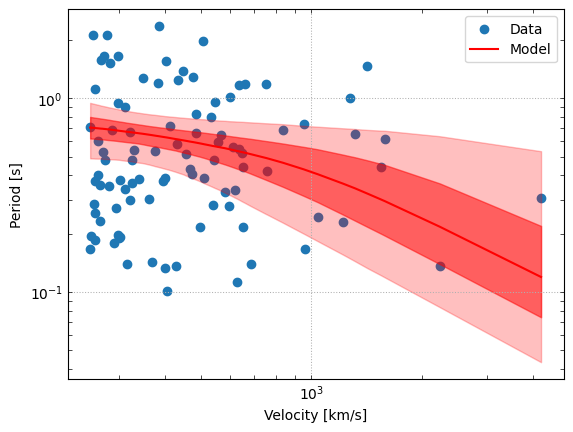

In [23]:
#############################
#   PLOTS
#############################

nsamples = nlive
palpha, palpha2 = 5, 25

nweights = res.weights/np.max(res.weights)
keepidx = np.where(np.random.rand(len(nweights)) < nweights)[0]
samples_nestle = res.samples[keepidx,:]

med_model, per_low, per_high, per_low2, per_high2 = sample_models(nsamples,samples_nestle,palpha,palpha2,x)

plt.scatter(vtr,per,color='C0',label='Data')
plt.plot(vtr,med_model, color='red',label='Model')
plt.fill_between(vtr,per_low,per_high,color='red',alpha=0.25)
plt.fill_between(vtr,per_low2,per_high2,color='red',alpha=0.5)
plt.xlabel('Velocity [km/s]')
plt.ylabel('Period [s]')
plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.grid(linestyle=':',linewidth='0.75')
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

plt.savefig('pulsars.pdf', format='pdf', dpi=1000, bbox_inches='tight')

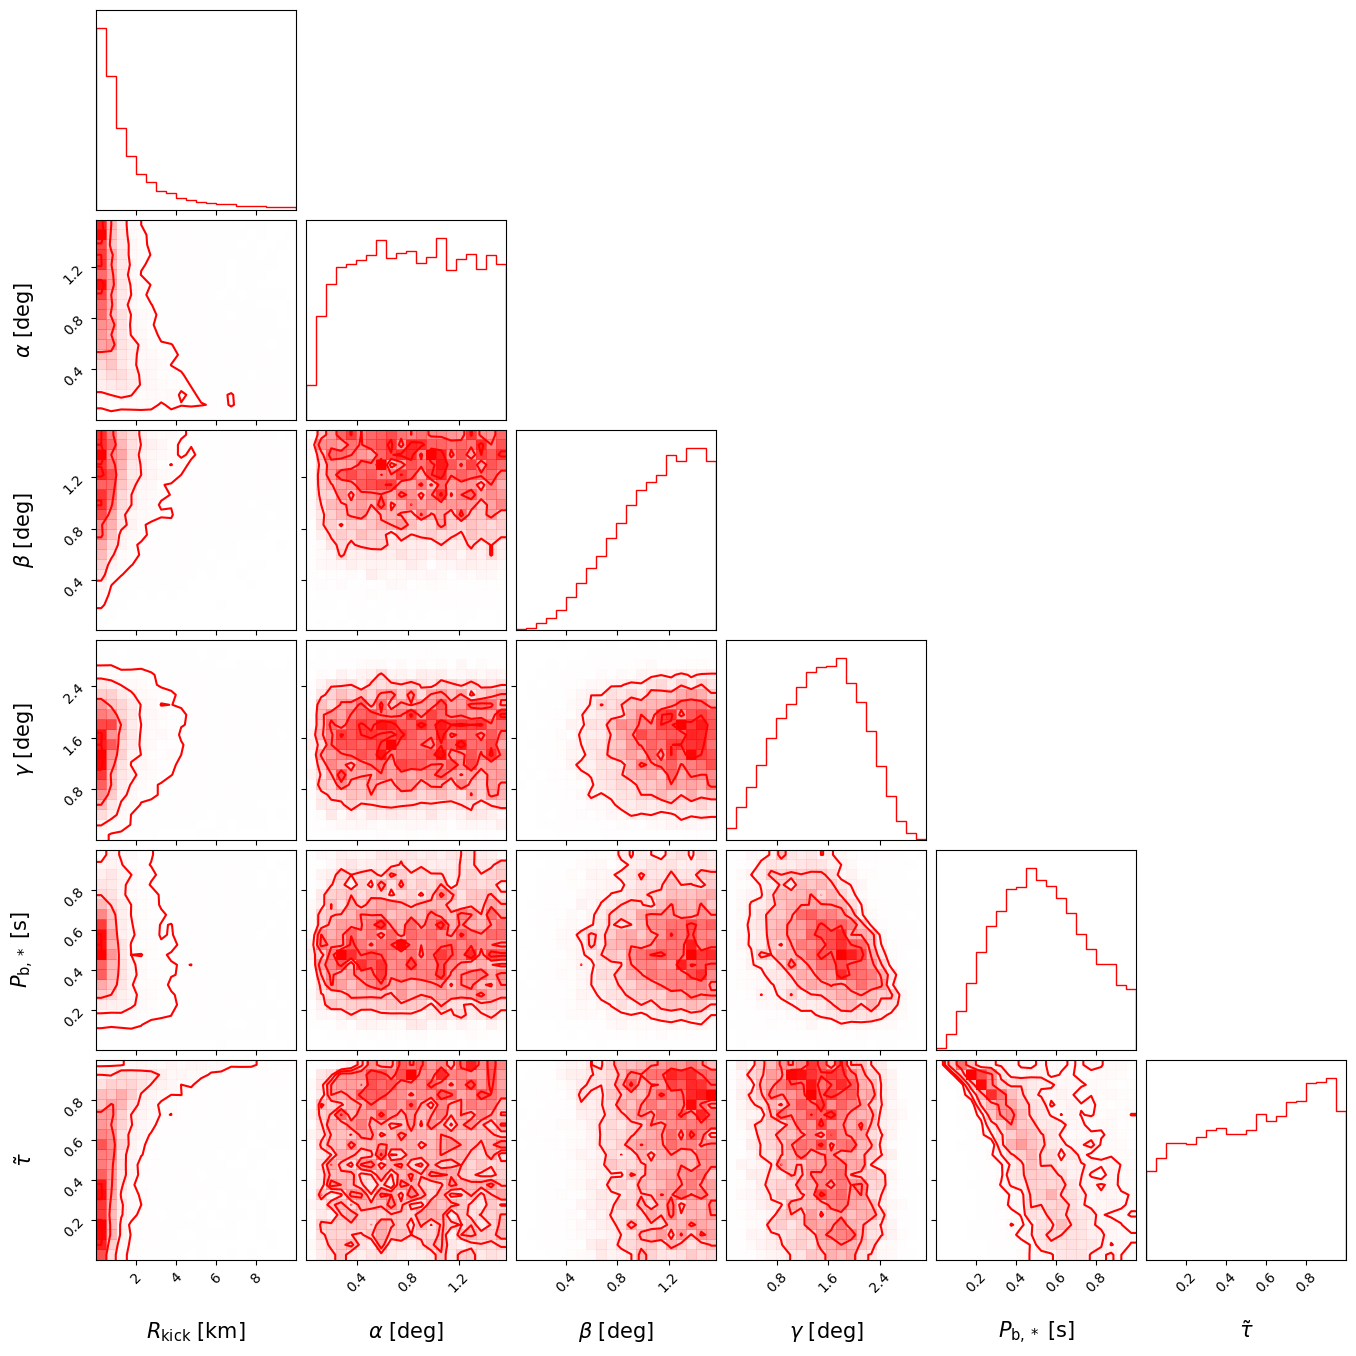

In [21]:
# corner plot

labels = ['$R_\mathrm{kick}$ [km]', '$\\alpha$ [deg]', '$\\beta$ [deg]', '$\\gamma$ [deg]', '$P_\mathrm{b,*}$ [s]', '$\~\\tau$']
fig = corner.corner(res.samples, weights=res.weights, show_titles=False,labels=labels,plot_datapoints=False,color='red',label_kwargs={"fontsize": 15})